In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import time
from datetime import timedelta

In [22]:
try:
    import geemap, ee, wxee, eemont
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap
        !pip install wxee
        !pip install eemont
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !conda install wxee -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !mamba install eemont -c conda-forge -y
    import geemap, ee, wxee, eemont

In [23]:
try:
        geemap.ee_initialize()
except Exception as e:
        geemap.ee_initialize()
        geemap.ee_initialize()

from geemap import geojson_to_ee, ee_to_geojson

In [24]:
chicago_final= pd.read_csv('/content/data/DataAfterSelectionandPreprocessing/chicago_final.csv')

In [25]:
volos_turbo_final  = pd.read_csv('/content/data/DataAfterSelectionandPreprocessing/volos_turbo_final.csv')
volos_turbo_final

,VgNIRBI,PISI,NDVI,EMBI,VrNIRBI,IBI,NDBI,cf_cvg,avg_rad,label
0,-0.156262,0.057925,0.069752,-0.089758,-0.069752,-15.913936,-0.010811,NaN,70.093898,0
1,-0.163073,0.054353,0.129827,-0.124079,-0.129827,-0.019400,-0.044529,NaN,70.093898,0
2,-0.152122,0.073200,0.101133,-0.027589,-0.101133,-0.673711,0.087293,NaN,70.093898,0
3,-0.279784,0.023549,0.288706,-0.124254,-0.288706,0.978246,-0.123526,NaN,70.093898,0
4,-0.226384,0.048742,0.194209,-0.024817,-0.194209,-2.934090,0.011797,NaN,70.093898,0
...,...,...,...,...,...,...,...,...,...,...
9821,-0.235897,0.019614,0.178426,-0.045459,-0.178426,2.214779,0.003865,14.0,68.900002,1
9822,-0.219015,0.029755,0.152598,-0.043590,-0.152598,-3.224787,0.018013,14.0,68.900002,1
9823,-0.219015,0.029755,0.152598,-0.043590,-0.152598,-3.224787,0.018013,14.0,68.900002,1
9824,-0.219015,0.029755,0.152598,-0.043590,-0.152598,-3.224787,0.018013,14.0,74.459999,1


In [26]:
X1=volos_turbo_final[['NDVI','NDBI','EMBI','PISI','VgNIRBI','VrNIRBI','avg_rad']]
y1=volos_turbo_final['label']

In [27]:
from scipy.stats.stats import pearsonr,spearmanr,kendalltau
coef, p = spearmanr(X1['VgNIRBI'], X1['avg_rad'])
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Samples are correlated (reject H0) p=0.000


In [28]:
kendalltau(X1['PISI'], X1['avg_rad'])

KendalltauResult(correlation=0.18871015353193576, pvalue=9.388481739971385e-169)

In [29]:
spearmanr(X1['PISI'], X1['avg_rad'])


SpearmanrResult(correlation=0.2733359794575748, pvalue=6.599881957175696e-168)

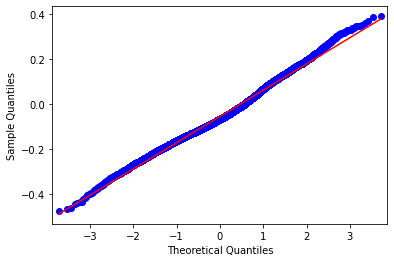

In [30]:
# QQ Plot
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# seed the random number generator
seed(1)
# generate univariate observations
#data = 5 * randn(100) + 50
# q-q plot
qqplot(volos_turbo_final['EMBI'], line='s')
pyplot.show()

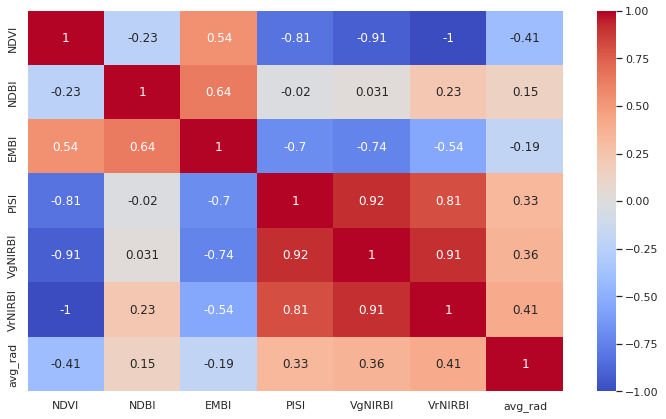

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(rc = {'figure.figsize':(12,7)})
sns.heatmap(X1.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [32]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score

one_class_svm = OneClassSVM(nu=0.3 ,kernel="rbf",gamma='auto')
trainX = volos_turbo_final[volos_turbo_final['label']==0].drop(['cf_cvg','label','IBI','NDBI','VgNIRBI',
                                                             'VrNIRBI' ,'PISI','NDVI'],axis=1)
one_class_svm.fit(trainX)
#yhat = model.predict(volos_turbo_viirs.drop(['date','building','id','@id','reducer','type','building:levels'],axis=1))
one_class_svm.score_samples(trainX)
#score = f1_score(testy, yhat, pos_label=-1)
#print('F1 Score: %.3f' % score)

array([54.01179461, 53.89981685, 54.06595136, ..., 52.1127264 ,
       52.11355967, 52.15135077])

In [33]:
yhat = one_class_svm.predict(volos_turbo_final[volos_turbo_final['label']==1].drop(['cf_cvg','label','IBI','NDBI','VgNIRBI',
                                                             'VrNIRBI' ,'PISI','NDVI'],axis=1))
yhat

array([-1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1,
        1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,
        1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
       -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,
        1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [34]:
len(yhat)

272

In [35]:
len(yhat[yhat==-1])#PISI,VgNIRBI

100

In [36]:
# Change the above parameters to generate new model dumps for the application

In [37]:
import joblib
joblib.dump(one_class_svm, 'ocsvm_03_scale.pkl')

['ocsvm_03_scale.pkl']